In [1]:
# !pip install opencv-python
# !pip install matplotlib 
# !pip install tensorflow
# !pip install pandas

In [2]:
import cv2 
img = cv2.imread("../data/IMG_all/demo/cizgili_kadin.png")

In [3]:
label_map = {
    1: "top", 
    2: "bottom", 
    3: "dress"
}

from detector import DetectorTF2 

detector = DetectorTF2(
    "../trained_model/frozen_model_1/saved_model/", 
    labelmap= label_map,
    threshold=0.50
)

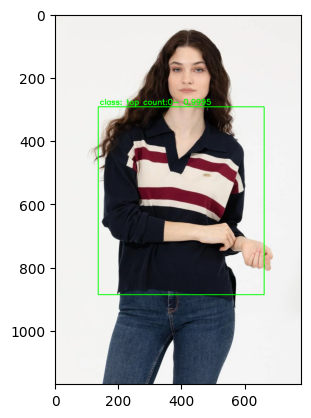

In [4]:
import matplotlib.pyplot as plt 

det_boxes = detector.DetectFromImage(img)
detected_img = detector.DisplayDetections(img, det_boxes) 

plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGBA))
plt.show() 

In [5]:
# !pip install scikit-image
# !pip install colormath

In [6]:
import cv2 
from skimage import color
import ast
import numpy as np 
from scipy.ndimage import binary_erosion

import pandas as pd 


def get_dominant_from_image_FeatureMethod_AreaAndThresholding(img_path:str, detector: DetectorTF2, zoom_rate = 2, max_palette = 5): 
    img = cv2.imread(img_path)
    actual_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    detected_img = img.copy()
    img = zoom_at(img, zoom_rate)

    # get dominant color 
    
    # biletarel filter 
    filtered_inRGB = cv2.bilateralFilter(img, 15, 75, 75)
    # cielab color format 
    img_inLAB_original = color.rgb2lab(filtered_inRGB) 
    
    # k-means 
    img_inLAB = img_inLAB_original.reshape((-1, 3))
    number_clusters = 10 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(np.float32(img_inLAB), number_clusters, None, criteria, 10, flags)

    # features 
    # area
    Aks = [sum(labels.ravel() == label)  for label in range(number_clusters)]
    max_Aks = max(Aks) 
    Aks = Aks / max_Aks 
    # saturation 
    Sks = np.array([calculate_saturation(lab_color) for lab_color in centers])
    max_Sk = max(Sks) 
    Sks = Sks / max_Sk
    # contrast 
    Cks = [calculate_contrast_lab(img_inLAB[(labels == label).squeeze()]) for label in range(10)] 
    max_Ck = max(Cks) 
    Cks = Cks / max_Ck
    Pks = Cks + Aks + Sks
    
    candidates = pd.DataFrame({"C": Cks, "A": Aks, "S": Sks, "p": Pks}, index=[str(tuple(center)) for center in centers])
    
    # remove boundry clusters 
    non_boundry_clusters = boundry_detection(centers, labels, img_inLAB_original.shape, verbose=False)

    # Thresholding 
    non_boundry_clusters = find_dissimilars(non_boundry_clusters, color_threshold=10)

    actual_candidates = candidates[candidates.index.isin([str(tuple(cls)) for cls in non_boundry_clusters])]
    first_dom = actual_candidates.sort_values(by="A", ascending=False).iloc[0, :].name
    actual_candidates.drop(index=first_dom, inplace=True) 
    second_dom = actual_candidates.sort_values(by="S", ascending=False).iloc[0, :].name
    actual_candidates.drop(index=second_dom, inplace=True) 
    actual_candidates.sort_values(by="p", ascending=False, inplace=True) 
    selected_dominant_colors = [first_dom, second_dom] + actual_candidates.iloc[:max_palette - 2 , :].index.tolist() 

    selected_dominant_colors = [ast.literal_eval(color) for color in selected_dominant_colors]
    rgb_colors = [convert_color(LabColor(lab_color[0], lab_color[1], lab_color[2]), sRGBColor).get_upscaled_value_tuple() for lab_color in selected_dominant_colors] 

    return actual_img, img, detected_img, rgb_colors

In [7]:
def report_image(path, alg, palette):
    actual_img, img, detected_img, rgb_colors = alg(path, detector, 2, max_palette=palette) 

    x_point = -100
    for c in rgb_colors: 
        x_point += 100 
        actual_img = cv2.rectangle(actual_img, (x_point, 0), (x_point+100, 200), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 

    image1 = cv2.resize(img, (400, 400))
    image2 = cv2.resize(detected_img, (400, 400))
    image3 = cv2.resize(actual_img, (400, 400))

    total_width = image1.shape[1] + image2.shape[1] + image3.shape[1]
    max_height = max(image1.shape[0], image2.shape[0], image3.shape[0])
    merged_image = np.zeros((max_height, total_width, 3), dtype=np.uint8)

    # Paste the images onto the blank image
    merged_image[:image1.shape[0], :image1.shape[1]] = image1
    merged_image[:image2.shape[0], image1.shape[1]:image1.shape[1]+image2.shape[1]] = image2
    merged_image[:image3.shape[0], image1.shape[1]+image2.shape[1]:] = image3

    return merged_image 

In [8]:
def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w, _ = [ zoom * i for i in img.shape ]
    
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize(img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
               : ]
    
    return img


import math 
def calculate_saturation(lab_color: list):
    """
        - lab_color: color values in CIELAB Color space. Ex: [xx, xx, xx] = [L, a, b]
    """
    return math.sqrt(lab_color[1] ** 2 + lab_color[2] ** 2)


def calculate_contrast_lab(lab_values):
    L_values = [color[0] for color in lab_values]
    L_max = np.max(L_values)
    L_min = np.min(L_values)

    contrast = (L_max - L_min) / L_min # TO DO: zero division error !

    return contrast

In [9]:
from math import ceil 
import warnings 
warnings.filterwarnings("ignore")
from skimage import color

def boundry_detection(centers, labels, actual_shape: tuple, verbose=True): 
    segmented_image = centers[labels.ravel()].reshape(actual_shape) 
    # plt.title("Segmented Image with K-Means Clusters")
    # rgb_image = color.lab2rgb(segmented_image)
    # plt.imshow(rgb_image)
    # plt.axis('off')
    # plt.show()

    # create masks 
    non_boundry_clusters = [] 
    for center in centers: 
        x = np.array(center)
        mask = np.all(segmented_image == x, axis=2)
        masked_image = np.copy(segmented_image)
        masked_image[~mask] = 0  # white 
        masked_image[mask] = 255 # black 

        eroded_mask = binary_erosion(mask, iterations=10)
        boundry_title = "Boundry"
        if np.count_nonzero(eroded_mask.ravel().ravel()) > 0: 
            non_boundry_clusters.append(center) 
            boundry_title = "Not Boundry"
        
        if verbose:
            fig, axes = plt.subplots(nrows=1, ncols=2) 
            axes[0].imshow(color.lab2rgb(masked_image),cmap='gray') 
            axes[0].axis('off')
            axes[0].set_title(f"Mask For Cluster {center}", fontsize=8)
            axes[1].imshow(eroded_mask, cmap='gray') 
            axes[1].axis("off")
            axes[1].set_title(f"Eroded Mask {boundry_title}", fontsize=8)
            plt.show()

    return non_boundry_clusters 

In [10]:
from skimage import color
from colormath.color_objects import LabColor, sRGBColor 
from colormath.color_conversions import convert_color

def delta_e(c1, c2):
    return color.deltaE_ciede2000(c1, c2)


def find_dissimilars(colors, color_threshold = 10):
    dissimilar_colors = []

    for i in range(len(colors)):
        color1 = colors[i] 
        is_dissimilar = True 
        for j in range(len(dissimilar_colors)):
            color2 = dissimilar_colors[j] 
            if delta_e(color1, color2) < color_threshold: 
                is_dissimilar = False
                break 
        
        if is_dissimilar:
            dissimilar_colors.append(color1)
    
    return dissimilar_colors

In [11]:
im = report_image("../data/IMG_all/demo/c7714214-7bf4-497e-8552-ed9ae0cacdf7_size780x1170_quality100_cropCenter.png", get_dominant_from_image_FeatureMethod_AreaAndThresholding, 4)

In [12]:
import os 

path = "\\\Aydplanlama\\e\\datasets\\IMG_all\\train"
output_dir = "\\\Aydplanlama\\e\\datasets\\IMG_all\\color_detection\\color_detection_thresholding_alg"
errors = [] 

for dir in os.scandir(path): 
    if dir.is_dir(): 
        for file in os.scandir(dir.path): 
            _, file_extension = os.path.splitext(file.path)
            if file.is_file() and file_extension in [".png", ".jpg", ".jpeg"]:
                ch = os.path.join(output_dir, dir.name)
                if not os.path.isdir(ch):
                    os.mkdir(ch)
                ch = os.path.join(ch, file.name)
                if os.path.isfile(ch): 
                    print(f"already exist {file.path}")
                    continue
                                
                # make predictions 
                try:
                    image = report_image(file.path, get_dominant_from_image_FeatureMethod_AreaAndThresholding, 4) 
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    cv2.imwrite(ch, image) 
                except: 
                    errors.append(file.name)

errors